In [36]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import warnings

In [37]:
# Download historical VIX data

vix_data = yf.download("^VIX", start='2023-01-01', end='2024-01-01', progress=False)

vix_data.to_csv("VIX_prices.csv")

vix_data.head()

Price,Close,High,Low,Open,Volume
Ticker,^VIX,^VIX,^VIX,^VIX,^VIX
Date,,,,,
2023-01-03,22.900000,23.76,22.730000,23.090000,0
2023-01-04,22.010000,23.27,21.940001,22.930000,0
2023-01-05,22.459999,22.92,21.969999,22.200001,0
2023-01-06,21.129999,22.90,21.000000,22.690001,0
2023-01-09,21.969999,21.98,21.270000,21.750000,0


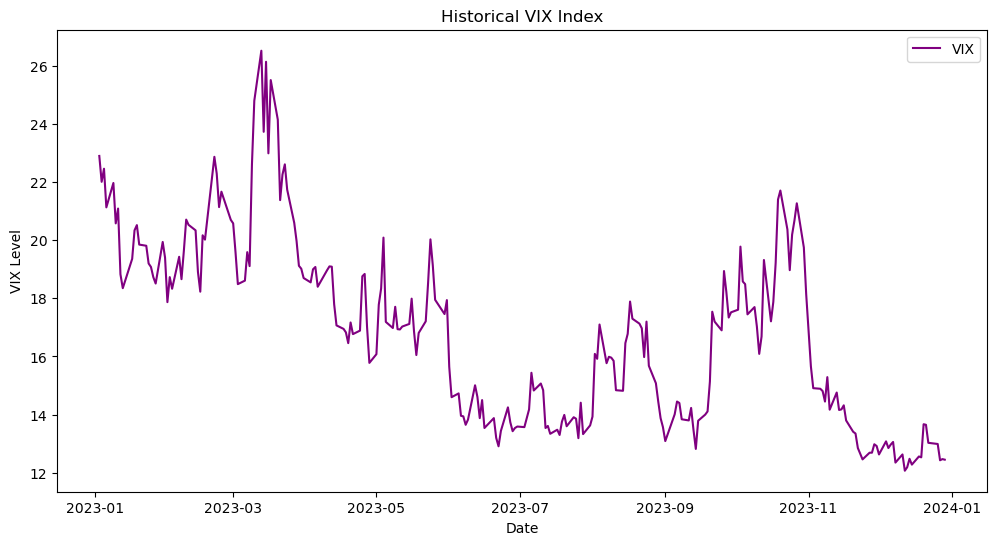

In [38]:
# Plot the VIX time series
plt.figure(figsize=(12, 6))
plt.plot(vix_data['Close'], label="VIX", color="purple")
plt.title("Historical VIX Index")
plt.xlabel("Date")
plt.ylabel("VIX Level")
plt.legend()
plt.show()

In [39]:
# Cleaning and scaling

from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")

scaler = MinMaxScaler()

vix_data = vix_data[['Close']]

vix_data.fillna(method='ffill', inplace=True)

vix_data['Scaled Close'] = scaler.fit_transform(vix_data['Close'])


In [40]:
# Sequences 

sequence_length = 10

def create_sequences(data, seq_length):
    sequences = []
    targets = []

    for i in range(len(data)-seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])

    return np.array(sequences), np.array(targets)

X_vix, y_vix = create_sequences(vix_data['Close'].values, sequence_length)

In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split

In [42]:
# Reshape data for LSTM (LSTM expects shape: samples, timesteps, features)

X_vix = np.expand_dims(X_vix, axis =1)

# Split the dataset

X_train, X_test, y_train, y_test = train_test_split(X_vix, y_vix, test_size=0.2, shuffle=False)

In [43]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape = input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation="relu"),
        Dense(1)
    ])

    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

# Define model

lstm_vix = build_lstm_model((X_train.shape[1],X_train.shape[2]))

# Print summary

lstm_vix.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 1, 50)          │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,701 (131.64 KB)

 Trainable params: 33,701 (131.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model

history = lstm_vix.fit(X_train, y_train,
                        epochs=20, batch_size=32,
                        validation_data= (X_test,y_test))

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 307.0553 - val_loss: 208.2065
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 303.9788 - val_loss: 202.4264
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 291.7553 - val_loss: 193.8842
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 275.7730 - val_loss: 181.6818
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 250.4083 - val_loss: 164.5701
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 244.8707 - val_loss: 140.5850
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 216.1669 - val_loss: 109.5710
Epoch 8/20
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 179.1456

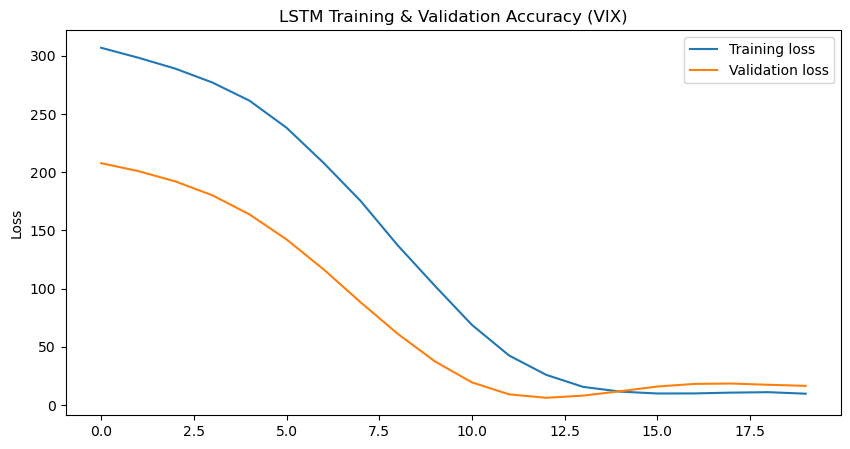

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label = "Training loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.legend()
plt.title("LSTM Training & Validation Accuracy (VIX)")
plt.ylabel("Loss")
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 380ms/step


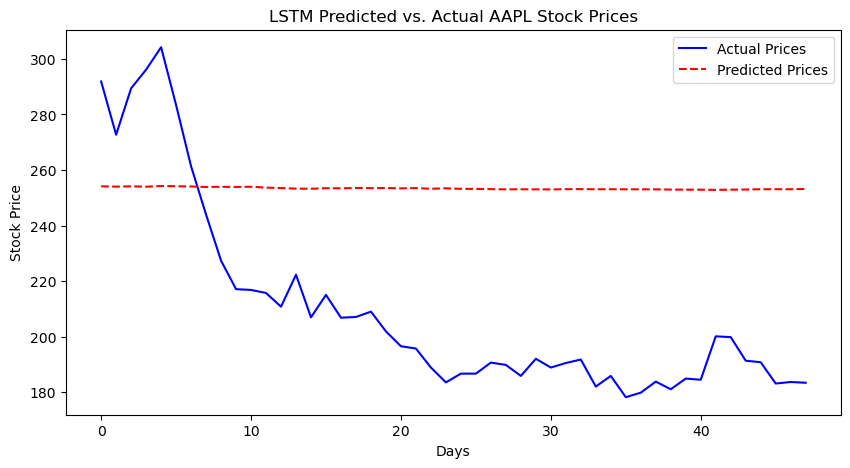

In [ ]:
# Get model predictions on the test set
y_pred = lstm_vix.predict(X_test)

# Scale data back to original range

scaler.fit(y_train.reshape(-1, 1))
y_pred_rescaled = scaler.inverse_transform(y_pred) 
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)) 

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label="Actual Prices", color="blue")
plt.plot(y_pred_rescaled, label="Predicted Prices", color="red", linestyle="dashed")
plt.legend()
plt.title("LSTM Predicted vs. Actual AAPL Stock Prices")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.show()